In [38]:
import sys
sys.path.append('../')

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
import tensorflow_probability as tfp
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle

from functools import partial
from tqdm.notebook import tqdm
# print(tqdm.__version__)

from models import DeepConditionalModel, InvariantNetwork
from losses import maximum_likelihood_loss
from inn_utils import train_online_ml
# from viz import plot_losses, plot_metrics_params


from sklearn.neighbors import KernelDensity
import random
import multiprocessing as mp
import psutil
import pickle
import os
import re
import scipy as scp
from scipy.stats import gamma
import time

import cddm_data_simulation as cds
import kde_training_utilities as kde_util
import kde_class as kde
import boundary_functions as bf

1.15.0


In [2]:
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
tf.enable_eager_execution()

In [4]:
# Example for data_generator function which is to be passed to the model
def gaussian(batch_size):
    mean = np.random.uniform(0,1,batch_size)
    var = np.random.uniform(0,2,batch_size)
    
    X_train = []
    
    for i in range(batch_size):
        a = np.random.normal(mean[i], var[i], 1000)
        X_train.append(a)
        
    X_train = np.array(X_train)    
    
    param = np.concatenate((mean.reshape(-1, 1), var.reshape(-1, 1)), axis=1)
    
    return tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(param, dtype=tf.float32)

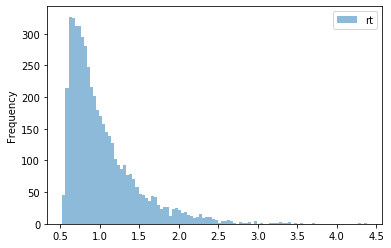

In [5]:
# Plotting rt from sampled data
out = cds.ddm_flexbound(v=0, a=1, w=0.5,
                    ndt = 0.5,
                    delta_t = 0.001, 
                    s = np.sqrt(2),
                    max_t = 20,
                    n_samples = 5000,
                    boundary_fun = bf.constant,
                    boundary_multiplicative = True, 
                    boundary_params = {})
                    #boundary_params = {"theta": 0.01})

data = np.concatenate((out[0].T, out[1].T),axis=1) 
data.shape
df = pd.DataFrame(
    out[0],
    columns = ['rt'])

df.plot.hist(bins=100, alpha=0.5)

In [47]:
# Data generator function for 2-choice data using ddm_flexbound
def data_generator_ddm_flexbound(batch_size):
    v = np.random.uniform(-3, 3, batch_size)
    a = np.random.uniform(0.3, 2.5, batch_size)
    w = np.random.uniform(0.1, 0.9, batch_size)
    
    # Number of paths to be sampled for each batch    
    n_samples = 10000 
    
    # Bool to determine how to put 'rt' and 'choice_made' together
    multiply = True 
    
    boundary_function = bf.constant
        
    X_train = []

    for i in range(batch_size):
        out = cds.ddm_flexbound(v[i], 
                                a[i], 
                                w[i],
                                ndt = 0.5,
                                delta_t = 0.001, 
                                s = np.sqrt(2),
                                max_t = 20,
                                n_samples = n_samples,
                                boundary_fun = boundary_function,
                                boundary_multiplicative = True, 
                                boundary_params = {})
                                #boundary_params = {"theta": 0.01})
        if multiply:
            # Multiply 'rt' and 'choice_made'
            data = (out[0]*out[1]).reshape(n_samples, )
        else:        
            # concatenate 'rt' and 'choice_made'
            data = np.concatenate((out[0].T, out[1].T), axis=1).reshape(2*n_samples,) 
            
        X_train.append(data)    
        
    X_train = np.array(X_train)         
    # Concatenating a, v and w
    param = np.concatenate((a.reshape(-1, 1), v.reshape(-1, 1), w.reshape(-1, 1)), axis=1)
    
    return tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(param, dtype=tf.float32)
    

# start = time.time()
# a, b = data_generator_ddm_flexbound(100)    
# end = time.time()
# print("Data generation took: {} time".format(end - start))
# print(a.shape)

In [45]:
# Data generator function for 2-choice data using Levy_flexbound
def data_generator_levy_flexbound(batch_size):
    v = np.random.uniform(-3, 3, batch_size)
    a = np.random.uniform(0.3, 2.0, batch_size)
    w = np.random.uniform(0.1, 0.9, batch_size)
    
    # Number of paths to be sampled for each batch    
    n_samples = 10000 
    
    # Bool to determine how to put 'rt' and 'choice_made' together
    multiply = True 
        
    boundary_function = bf.constant
    
    X_train = []

    for i in range(batch_size):
        out = cds.levy_flexbound(v[i], 
                                 a[i],
                                 w[i],
                                 alpha_diff = 1.5,
                                 ndt = 0.5,
                                 delta_t = 0.001, 
                                 max_t = 20,
                                 n_samples = n_samples,
                                 boundary_fun = boundary_function,
                                 boundary_multiplicative = True, 
                                 boundary_params = {})
                                #boundary_params = {"theta": 0.01})
        if multiply:
            # Multiply 'rt' and 'choice_made'
            data = (out[0]*out[1]).reshape(n_samples, )
        else:        
            # concatenate 'rt' and 'choice_made'
            data = np.concatenate((out[0].T, out[1].T), axis=1).reshape(2*n_samples,) 
            
        X_train.append(data)    
        
    X_train = np.array(X_train)         
    # Concatenating a, v and w
    param = np.concatenate((a.reshape(-1, 1), v.reshape(-1, 1), w.reshape(-1, 1)), axis=1)
    
    return tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(param, dtype=tf.float32)

start = time.time()
a, b = data_generator_levy_flexbound(100)    
end = time.time()
print("Data generation took: {} time".format(end - start))

Data generation took: 58.81531476974487 time


In [48]:
def load_model_and_opt(n_inv_blocks, global_step):
    """Loads a GMM model given the number of invertible blocks."""
    
    # Create model
    model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Checkpoint model
    checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
    manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ddm_flexbound_{}'.format(n_inv_blocks), max_to_keep=2)
    checkpoint.restore(manager.latest_checkpoint)
    
    return model, optimizer, manager

In [49]:
def train_model(n_inv_blocks):
    """
    Runs the Gausian Distribution
    """
    
    model, optimizer, manager = load_model_and_opt(n_inv_blocks, global_step)
    
    for ep in range(1, epochs+1):
        with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:

            # Run training loop
            train_online_ml(model, optimizer, data_generator_ddm_flexbound, iterations_per_epoch, 
                            batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
                            transform=None, n_smooth=100)
            
            manager.save()

In [52]:
# Setting the various configurations
inv_meta = {
    'n_units': [128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

n_inv = 10
theta_dim = 3
# params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tf.Variable(0, dtype=tf.int32)
batch_size = 50
epochs = 20
iterations_per_epoch = 100
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .99
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

In [ ]:
train_model(n_inv)

In [173]:
model, _, _ = load_model_and_opt(8, global_step)

# a = np.random.normal(0, 1.7, 1000).reshape(1, -1)
# a = np.random.uniform(1,4,batch_size)
# v = np.random.uniform(0,0.5,batch_size)



out = cds.ddm_flexbound(v=0.1, a=2, w=0.5,
                            ndt = 0.5,
                            delta_t = 0.001, 
                            s = np.sqrt(2),
                            max_t = 20,
                            n_samples = 500,
                            boundary_fun = bf.constant,
                            boundary_multiplicative = True, 
                            boundary_params = {})
                            #boundary_params = {"theta": 0.01})
# data = np.concatenate((out[0].T, out[1].T), axis=1).reshape(1,-1)  

# X_train = np.array(X_train)         
# param = np.concatenate((a.reshape(-1, 1), v.reshape(-1, 1)), axis=1)

# print(out[0])
    
a = tf.convert_to_tensor(out[0].reshape(1,500), dtype=tf.float32)
print(a.shape)

(1, 500)


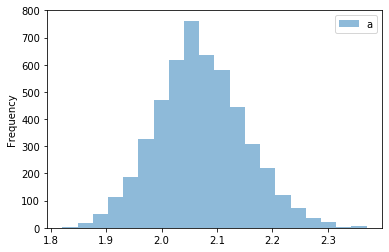

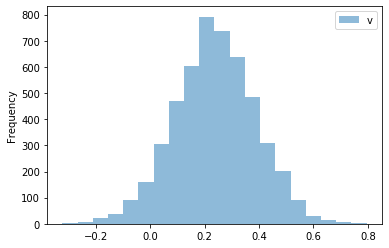

In [175]:
samples_theta = model.sample(a, 5000).numpy()
# print(samples_theta)
# print(samples_theta)
b = pd.qcut(samples_theta[:, 0], q=10)

df = pd.DataFrame(
    samples_theta[:, 0],
    columns = ['a'])

df.plot.hist(bins=20, alpha=0.5)

var = pd.DataFrame(
    samples_theta[:, 1],
    columns = ['v'])

var.plot.hist(bins=20, alpha=0.5)

In [176]:
np.mean(samples_theta, axis=0)

array([2.0710387 , 0.23769441], dtype=float32)